Connected to py35 (Python 3.5.6)

In [ ]:
import numpy as np
from bpca import BPCA
# from bpca_pymc import BPCA
import matplotlib.pyplot as plt

np.random.seed(0)  # For reproducibility


# hinton diagram
def hinton(matrix, max_weight=None, ax=None):
    """Draw Hinton diagram for visualizing a weight matrix."""
    ax = ax if ax is not None else plt.gca()

    matrix_t = matrix.T

    if not max_weight:
        max_weight = 2 ** np.ceil(np.log(np.abs(matrix_t).max()) / np.log(2))

    ax.patch.set_facecolor('gray')
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    for (x, y), w in np.ndenumerate(matrix_t):
        color = 'white' if w > 0 else 'black'
        size = np.sqrt(np.abs(w) / max_weight)
        rect = plt.Rectangle([x - size / 2, y - size / 2], size, size,
                             facecolor=color, edgecolor=color)
        ax.add_patch(rect)

    ax.autoscale_view()
    ax.invert_yaxis()


def simulate_data(psi=1, N=100, P=10):
    psi_inv = 1 / psi
    cov = np.diag([5, 4, 3, 2] + [psi_inv] * (P - 4))

    # # Generate a random orthogonal matrix U
    # random_matrix = np.random.randn(P, P)
    # U, _, _ = np.linalg.svd(random_matrix)
    
    # Transform the covariance matrix
    # cov = U @ cov @ U.T

    return np.random.multivariate_normal(np.zeros(P), cov, N)

In [ ]:
from scipy.stats import multivariate_normal as mvn, gamma

class GibbsBayesianPCA:
    def __init__(
        self, t, q, a_alpha=1e-3, b_alpha=1e-3, a_tau=1e-3, b_tau=1e-3, beta=1e-3,
        tau_init=None, 
        ):
        self.t = t
        self.N, self.d = t.shape
        self.q = q
        self.a_alpha = a_alpha
        self.b_alpha = b_alpha
        self.a_tau = a_tau
        self.b_tau = b_tau
        self.beta = beta
        self.initialize_parameters(tau_init=tau_init)

    def initialize_parameters(
        self,
        tau_init=None,
        ):
        self.x = np.random.randn(self.N, self.q)
        self.mu = np.zeros((1, self.d))
        self.W = np.random.randn(self.d, self.q)
        self.alpha = gamma.rvs(self.a_alpha, scale=1/self.b_alpha, size=self.q)
        # self.tau = gamma.rvs(self.a_tau, scale=1/self.b_tau)
        # HACK
        # b_tau_tilde= np.abs(np.random.randn(1))
        # a_tau_tilde = self.a_tau + 0.5 * self.N * self.d
        # self.tau = gamma.rvs(a_tau_tilde, scale=1/b_tau_tilde)
        self.tau = 1 if tau_init is None else tau_init
        # b_tau_tilde = self.b_tau_tilde * self.tau

        self.Iq = np.eye(self.q)
        self.Id = np.eye(self.d)


    def update_x(self):
        Sigma_x = np.linalg.inv(self.Iq + self.tau * self.W.T @ self.W)
        m_x = self.tau * Sigma_x @ self.W.T @ (self.t - self.mu).T
        for n in range(self.N):
            # m_x_n = self.tau * Sigma_x @ self.W.T @ (self.t[[n]] - self.mu).T
            m_x_n = m_x[:, [n]]
            self.x[[n]] = mvn.rvs(mean=m_x_n.flatten(), cov=Sigma_x)

    def update_mu(self):
        Sigma_mu = np.linalg.inv(self.beta * self.Id + self.N * self.tau * self.Id)
        m_mu = self.tau * Sigma_mu @ np.sum(self.t - self.x @ self.W.T, axis=0)
        self.mu = mvn.rvs(mean=m_mu, cov=Sigma_mu)[None, :]

    def update_W(self):
        Sigma_w = np.linalg.inv(np.diag(self.alpha) + self.tau * self.x.T @ self.x)
        m_w = self.tau * Sigma_w @ self.x.T @ (self.t - self.mu)
        for k in range(self.d):
            # m_w_k = self.tau * Sigma_w @ self.x.T @ (self.t[:, [k]] - self.mu[:,[k]])
            m_w_k = m_w[:, [k]]
            self.W[k] = mvn.rvs(mean=m_w_k.flatten(), cov=Sigma_w)

    def update_alpha(self):
        a_alpha_tilde = self.a_alpha + 0.5 * self.d
        b_alpha_tilde = self.b_alpha + 0.5 * np.sum(self.W ** 2, axis=0)
        for i in range(self.q):
            # b_alpha_tilde_i = self.b_alpha + 0.5 * np.sum(self.W[:, i] ** 2)
            b_alpha_tilde_i = b_alpha_tilde[i]
            self.alpha[i] = gamma.rvs(a_alpha_tilde, scale=1/b_alpha_tilde_i)

    def update_tau(
        self,
        fix_tau_at=None,
        ):
        a_tau_tilde = self.a_tau + 0.5 * self.N * self.d
        # print(self.t[0].shape, self.mu.shape, self.W.shape, self.x[0].shape, self.tau)
        # n = 0
        # print( (self.x[n][:,None] @ self.x[n][:,None].T) )
        # print( np.trace(self.W.T @ self.W @ (self.x[n][:,None] @ self.x[n][:,None].T)) )
        # b_tau_tilde_ = self.b_tau + 0.5 * np.sum([
        #     np.linalg.norm(self.t[n])**2 + self.mu.T @ self.mu + np.trace(self.W.T @ self.W @ (self.x[n][:,None] @ self.x[n][:,None].T)) + 2 * self.mu @ self.W @ self.x[n] - 2 * self.t[[n]] @ self.W @ self.x[[n]].T - 2 * self.t[[n]] @ self.mu.T
        #     for n in range(self.N)
        # ])
        if fix_tau_at is None:
            
            b_tau_tilde = self.b_tau + 0.5 * (
                (self.t**2).sum() + (self.mu**2).sum()*self.N + np.trace(
                    self.W.T @ self.W @ (self.x.T @ self.x)
                ) + 2 * (self.mu @ self.W @ self.x.T).sum() + np.sum([
                    - 2 * self.t[[n]] @ self.W @ self.x[[n]].T 
                    for n in range(self.N)
                ]) - 2 * (self.t @ self.mu.T).sum()
            )
            self.tau = gamma.rvs(a_tau_tilde, scale=1/b_tau_tilde)
        else:
            self.tau = fix_tau_at
            b_tau_tilde = a_tau_tilde / self.tau


    def fit(
        self, 
        # params for the gibbs sampler
        iterations=500,
        burn_in=200,
        thinning=10,
        threshold_alpha_complete=None,
        true_signal_dim=None,
        fix_tau_at=None,
        ):

        # store the samples
        self.samples = {
            'x': [],
            'mu': [],
            'W': [],
            'alpha': [],
            'tau': [],
        }

        for i in range(iterations):
            self.iter_converge = iterations
            self.update_x()
            self.update_mu()
            self.update_W()
            self.update_alpha()
            self.update_tau( fix_tau_at=fix_tau_at )
            if (i + 1) % 100 == 0:
                print('Iteration ', ( i + 1 ))

            if i >= burn_in and i % thinning == 0:
                self.samples['x'].append(self.x)
                self.samples['mu'].append(self.mu)
                self.samples['W'].append(self.W)
                self.samples['alpha'].append(self.alpha)
                self.samples['tau'].append(self.tau)

                if (threshold_alpha_complete is not None) and ( true_signal_dim is not None ):
                    # mean of self.samples['alpha']
                    alpha_sorted = sorted(np.mean(self.samples['alpha'] , axis=0))
                    if (alpha_sorted[true_signal_dim] / alpha_sorted[true_signal_dim-1]) > threshold_alpha_complete:
                        self.iter_converge = i
                        break

In [ ]:
var_noise_list = np.logspace(-5, 1, 30)
threshold_alpha_complete = 1e2
iter_end_list = np.zeros(len(var_noise_list))
# variational inference
# n_iter_max = 200000
# gibbs
n_iter_max = 20000
n_repeat = 1

Completed Variance:  0.221221629107
Completed Variance:  0.137382379588
Completed Variance:  0.0853167852417
Completed Variance:  0.0529831690628
Completed Variance:  0.0329034456231
Completed Variance:  0.0204335971786
Completed Variance:  0.0126896100317
Completed Variance:  0.00489390091848
Completed Variance:  0.00788046281567
Completed Variance:  0.00188739182214
Completed Variance:  0.00303919538231
Completed Variance:  0.00117210229753
Completed Variance:  0.356224789026
Completed Variance:  1e-05
Completed Variance:  0.00017433288222
Completed Variance:  1.48735210729
Completed Variance:  2.39502661999
Completed Variance:  2.5929437974e-05
Completed Variance:  0.000108263673387
Completed Variance:  0.000280721620394
Completed Variance:  1.61026202756e-05
Completed Variance:  10.0
Completed Variance:  6.7233575365e-05
Completed Variance:  4.17531893656e-05
Completed Variance:  0.000452035365636
Completed Variance:  0.923670857187
Completed Variance:  6.21016941892
Completed Vari

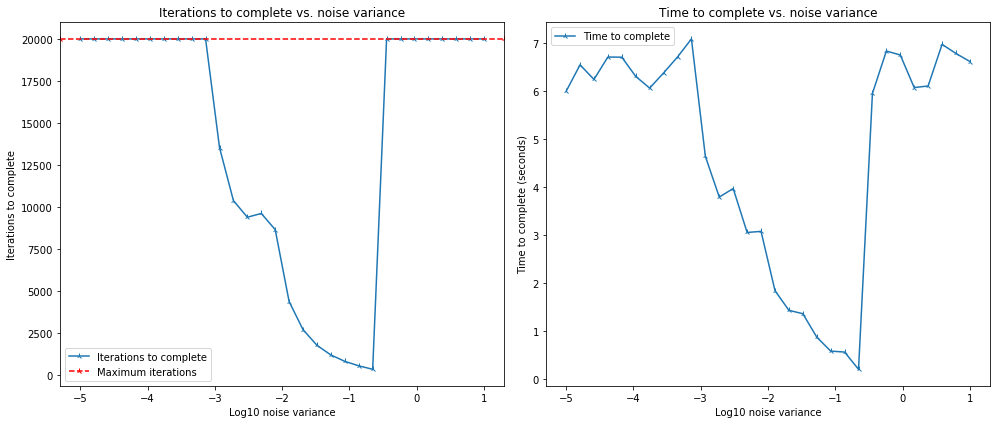

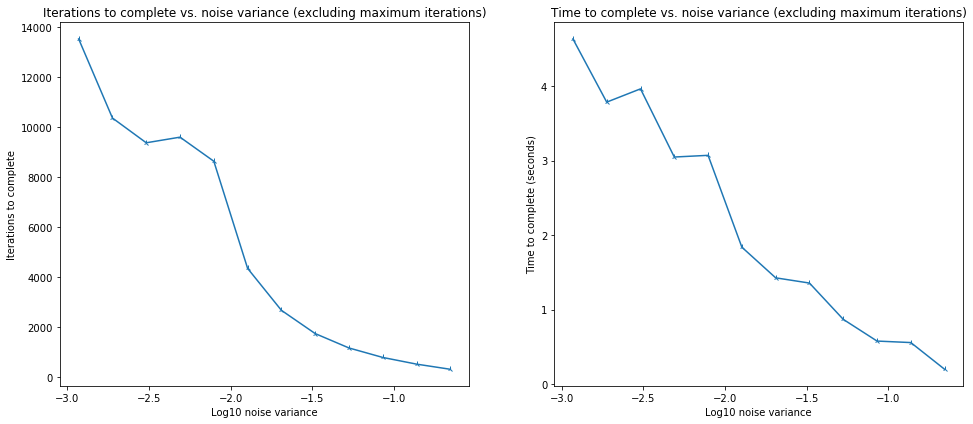

In [ ]:
import numpy as np
from concurrent.futures import ProcessPoolExecutor, as_completed
import matplotlib.pyplot as plt
import time

# Function to perform the simulation and fitting
def simulate_and_fit(v, n_repeat, n_iter_max, threshold_alpha_complete):
    iter_end_list_i = np.zeros(n_repeat)
    time_list_i = np.zeros(n_repeat)
    for j in range(n_repeat):
        start_time = time.time()
        d = simulate_data(psi=v**(-1), N=100)
        # variational inference
        bpca = BPCA(a_alpha=1e-3, b_alpha=1e-3, a_tau=1e-3, b_tau=1e-3, beta=1e-3)
        bpca.fit(
            d, iters=n_iter_max,
            threshold_alpha_complete=threshold_alpha_complete,
            true_signal_dim=4,
            fix_tau_at=v**(-1),
        )
        # gibbs
        # bpca = GibbsBayesianPCA(d, q=d.shape[1]-1, tau_init=v**(-1))
        # bpca.fit(
        #     iterations=n_iter_max,
        #     threshold_alpha_complete=threshold_alpha_complete,
        #     true_signal_dim=4,
        #     fix_tau_at=v**(-1),
        #     )
        iter_end_list_i[j] = bpca.iter_converge
        time_list_i[j] = time.time() - start_time
    return np.mean(iter_end_list_i), np.mean(time_list_i)


# Specify the number of worker processes (e.g., 4)
num_workers = 30

r_list = []
# Use ProcessPoolExecutor to parallelize the loop
with ProcessPoolExecutor(max_workers=num_workers) as executor:
    futures = {executor.submit(simulate_and_fit, v, n_repeat, n_iter_max, threshold_alpha_complete): v for v in var_noise_list}
    for future in as_completed(futures):
        v = futures[future]
        mean_iter, mean_time = future.result()
        r_list.append((v, mean_iter, mean_time))
        print('Completed Variance: ', v)

# sort r_list by variance
r_list = sorted(r_list, key=lambda x: x[0])
v_list, iter_end_list, time_list = zip(*r_list)
# Convert lists to numpy arrays for plotting
iter_end_list = np.array(iter_end_list)
time_list = np.array(time_list)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot the number of iterations to converge
ax1.plot(np.log10(v_list), iter_end_list, label='Iterations to complete', marker='2')
ax1.axhline(y=n_iter_max, color='r', linestyle='--', label='Maximum iterations', marker='2')
ax1.set_xlabel('Log10 noise variance')
ax1.set_ylabel('Iterations to complete')
ax1.set_title('Iterations to complete vs. noise variance')
ax1.legend()

# Plot the time to converge
ax2.plot(np.log10(v_list), time_list, label='Time to complete', marker='2')
ax2.set_xlabel('Log10 noise variance')
ax2.set_ylabel('Time to complete (seconds)')
ax2.set_title('Time to complete vs. noise variance')
ax2.legend()

# Show the plots
plt.tight_layout()
plt.show()

# Show results excluding those reaching the maximum number of iterations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot the number of iterations to converge excluding max iterations
ax1.plot(np.log10(v_list)[iter_end_list < n_iter_max], iter_end_list[iter_end_list < n_iter_max], marker='2')
ax1.set_xlabel('Log10 noise variance')
ax1.set_ylabel('Iterations to complete')
ax1.set_title('Iterations to complete vs. noise variance (excluding maximum iterations)')

# Plot the time to converge excluding max iterations
ax2.plot(np.log10(v_list)[iter_end_list < n_iter_max], time_list[iter_end_list < n_iter_max], marker='2')
ax2.set_xlabel('Log10 noise variance')
ax2.set_ylabel('Time to complete (seconds)')
ax2.set_title('Time to complete vs. noise variance (excluding maximum iterations)')

# Show the plots
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from bpca import BPCA
# from bpca_pymc import BPCA
import matplotlib.pyplot as plt

np.random.seed(0)  # For reproducibility


# hinton diagram
def hinton(matrix, max_weight=None, ax=None):
    """Draw Hinton diagram for visualizing a weight matrix."""
    ax = ax if ax is not None else plt.gca()

    matrix_t = matrix.T

    if not max_weight:
        max_weight = 2 ** np.ceil(np.log(np.abs(matrix_t).max()) / np.log(2))

    ax.patch.set_facecolor('gray')
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    for (x, y), w in np.ndenumerate(matrix_t):
        color = 'white' if w > 0 else 'black'
        size = np.sqrt(np.abs(w) / max_weight)
        rect = plt.Rectangle([x - size / 2, y - size / 2], size, size,
                             facecolor=color, edgecolor=color)
        ax.add_patch(rect)

    ax.autoscale_view()
    ax.invert_yaxis()


def simulate_data(psi=1, N=100, P=10):
    psi_inv = 1 / psi
    cov = np.diag([5, 4, 3, 2] + [psi_inv] * (P - 4))

    # # Generate a random orthogonal matrix U
    # random_matrix = np.random.randn(P, P)
    # U, _, _ = np.linalg.svd(random_matrix)
    
    # Transform the covariance matrix
    # cov = U @ cov @ U.T

    return np.random.multivariate_normal(np.zeros(P), cov, N)

In [ ]:
from scipy.stats import multivariate_normal as mvn, gamma

class GibbsBayesianPCA:
    def __init__(
        self, t, q, a_alpha=1e-3, b_alpha=1e-3, a_tau=1e-3, b_tau=1e-3, beta=1e-3,
        tau_init=None, 
        ):
        self.t = t
        self.N, self.d = t.shape
        self.q = q
        self.a_alpha = a_alpha
        self.b_alpha = b_alpha
        self.a_tau = a_tau
        self.b_tau = b_tau
        self.beta = beta
        self.initialize_parameters(tau_init=tau_init)

    def initialize_parameters(
        self,
        tau_init=None,
        ):
        self.x = np.random.randn(self.N, self.q)
        self.mu = np.zeros((1, self.d))
        self.W = np.random.randn(self.d, self.q)
        self.alpha = gamma.rvs(self.a_alpha, scale=1/self.b_alpha, size=self.q)
        # self.tau = gamma.rvs(self.a_tau, scale=1/self.b_tau)
        # HACK
        # b_tau_tilde= np.abs(np.random.randn(1))
        # a_tau_tilde = self.a_tau + 0.5 * self.N * self.d
        # self.tau = gamma.rvs(a_tau_tilde, scale=1/b_tau_tilde)
        self.tau = 1 if tau_init is None else tau_init
        # b_tau_tilde = self.b_tau_tilde * self.tau

        self.Iq = np.eye(self.q)
        self.Id = np.eye(self.d)


    def update_x(self):
        Sigma_x = np.linalg.inv(self.Iq + self.tau * self.W.T @ self.W)
        m_x = self.tau * Sigma_x @ self.W.T @ (self.t - self.mu).T
        for n in range(self.N):
            # m_x_n = self.tau * Sigma_x @ self.W.T @ (self.t[[n]] - self.mu).T
            m_x_n = m_x[:, [n]]
            self.x[[n]] = mvn.rvs(mean=m_x_n.flatten(), cov=Sigma_x)

    def update_mu(self):
        Sigma_mu = np.linalg.inv(self.beta * self.Id + self.N * self.tau * self.Id)
        m_mu = self.tau * Sigma_mu @ np.sum(self.t - self.x @ self.W.T, axis=0)
        self.mu = mvn.rvs(mean=m_mu, cov=Sigma_mu)[None, :]

    def update_W(self):
        Sigma_w = np.linalg.inv(np.diag(self.alpha) + self.tau * self.x.T @ self.x)
        m_w = self.tau * Sigma_w @ self.x.T @ (self.t - self.mu)
        for k in range(self.d):
            # m_w_k = self.tau * Sigma_w @ self.x.T @ (self.t[:, [k]] - self.mu[:,[k]])
            m_w_k = m_w[:, [k]]
            self.W[k] = mvn.rvs(mean=m_w_k.flatten(), cov=Sigma_w)

    def update_alpha(self):
        a_alpha_tilde = self.a_alpha + 0.5 * self.d
        b_alpha_tilde = self.b_alpha + 0.5 * np.sum(self.W ** 2, axis=0)
        for i in range(self.q):
            # b_alpha_tilde_i = self.b_alpha + 0.5 * np.sum(self.W[:, i] ** 2)
            b_alpha_tilde_i = b_alpha_tilde[i]
            self.alpha[i] = gamma.rvs(a_alpha_tilde, scale=1/b_alpha_tilde_i)

    def update_tau(
        self,
        fix_tau_at=None,
        ):
        a_tau_tilde = self.a_tau + 0.5 * self.N * self.d
        # print(self.t[0].shape, self.mu.shape, self.W.shape, self.x[0].shape, self.tau)
        # n = 0
        # print( (self.x[n][:,None] @ self.x[n][:,None].T) )
        # print( np.trace(self.W.T @ self.W @ (self.x[n][:,None] @ self.x[n][:,None].T)) )
        # b_tau_tilde_ = self.b_tau + 0.5 * np.sum([
        #     np.linalg.norm(self.t[n])**2 + self.mu.T @ self.mu + np.trace(self.W.T @ self.W @ (self.x[n][:,None] @ self.x[n][:,None].T)) + 2 * self.mu @ self.W @ self.x[n] - 2 * self.t[[n]] @ self.W @ self.x[[n]].T - 2 * self.t[[n]] @ self.mu.T
        #     for n in range(self.N)
        # ])
        if fix_tau_at is None:
            
            b_tau_tilde = self.b_tau + 0.5 * (
                (self.t**2).sum() + (self.mu**2).sum()*self.N + np.trace(
                    self.W.T @ self.W @ (self.x.T @ self.x)
                ) + 2 * (self.mu @ self.W @ self.x.T).sum() + np.sum([
                    - 2 * self.t[[n]] @ self.W @ self.x[[n]].T 
                    for n in range(self.N)
                ]) - 2 * (self.t @ self.mu.T).sum()
            )
            self.tau = gamma.rvs(a_tau_tilde, scale=1/b_tau_tilde)
        else:
            self.tau = fix_tau_at
            b_tau_tilde = a_tau_tilde / self.tau


    def fit(
        self, 
        # params for the gibbs sampler
        iterations=500,
        burn_in=200,
        thinning=10,
        threshold_alpha_complete=None,
        true_signal_dim=None,
        fix_tau_at=None,
        ):

        # store the samples
        self.samples = {
            'x': [],
            'mu': [],
            'W': [],
            'alpha': [],
            'tau': [],
        }

        for i in range(iterations):
            self.iter_converge = iterations
            self.update_x()
            self.update_mu()
            self.update_W()
            self.update_alpha()
            self.update_tau( fix_tau_at=fix_tau_at )
            if (i + 1) % 100 == 0:
                print('Iteration ', ( i + 1 ))

            if i >= burn_in and i % thinning == 0:
                self.samples['x'].append(self.x)
                self.samples['mu'].append(self.mu)
                self.samples['W'].append(self.W)
                self.samples['alpha'].append(self.alpha)
                self.samples['tau'].append(self.tau)

                if (threshold_alpha_complete is not None) and ( true_signal_dim is not None ):
                    # mean of self.samples['alpha']
                    alpha_sorted = sorted(np.mean(self.samples['alpha'] , axis=0))
                    if (alpha_sorted[true_signal_dim] / alpha_sorted[true_signal_dim-1]) > threshold_alpha_complete:
                        self.iter_converge = i
                        break

In [ ]:
var_noise_list = np.logspace(-5, 1, 30)
threshold_alpha_complete = 1e2
iter_end_list = np.zeros(len(var_noise_list))
# variational inference
# n_iter_max = 200000
# gibbs
n_iter_max = 20000
n_repeat = 1

Completed Variance:  0.221221629107
Completed Variance:  0.137382379588
Completed Variance:  0.0853167852417
Completed Variance:  0.0329034456231
Completed Variance:  0.0529831690628
Completed Variance:  0.0204335971786
Completed Variance:  0.0126896100317
Completed Variance:  0.00303919538231
Completed Variance:  0.00188739182214
Completed Variance:  0.00788046281567
Completed Variance:  0.00489390091848
Completed Variance:  10.0
Completed Variance:  4.17531893656e-05
Completed Variance:  0.00117210229753
Completed Variance:  0.000727895384398
Completed Variance:  1e-05
Completed Variance:  2.39502661999
Completed Variance:  6.7233575365e-05
Completed Variance:  0.923670857187
Completed Variance:  0.000452035365636
Completed Variance:  1.48735210729
Completed Variance:  2.5929437974e-05
Completed Variance:  0.000280721620394
Completed Variance:  1.61026202756e-05
Completed Variance:  3.85662042116
Completed Variance:  0.356224789026
Completed Variance:  0.000108263673387
Completed Var

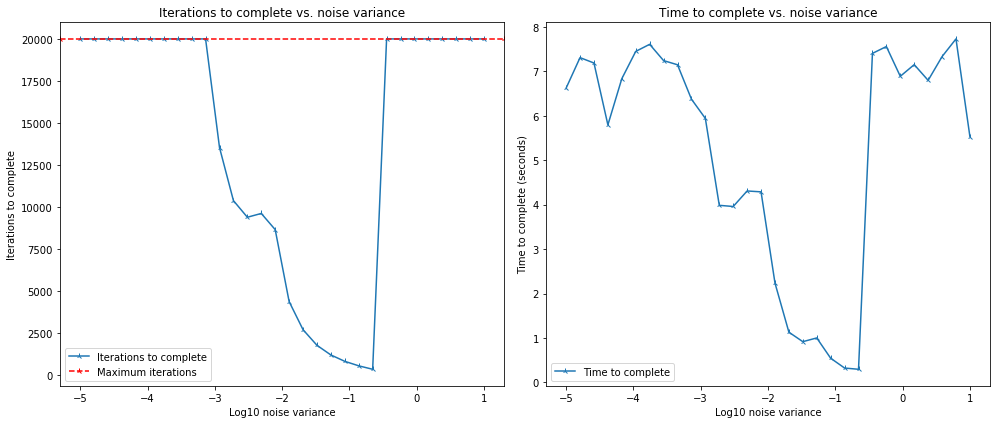

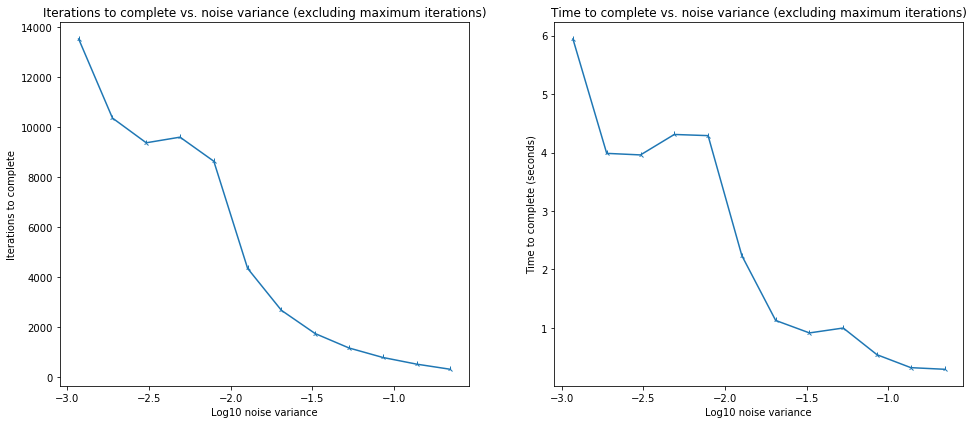

In [ ]:
import numpy as np
from concurrent.futures import ProcessPoolExecutor, as_completed
import matplotlib.pyplot as plt
import time

# Function to perform the simulation and fitting
def simulate_and_fit(v, n_repeat, n_iter_max, threshold_alpha_complete):
    iter_end_list_i = np.zeros(n_repeat)
    time_list_i = np.zeros(n_repeat)
    for j in range(n_repeat):
        start_time = time.time()
        d = simulate_data(psi=v**(-1), N=100)
        # variational inference
        bpca = BPCA(a_alpha=1e-3, b_alpha=1e-3, a_tau=1e-3, b_tau=1e-3, beta=1e-3)
        bpca.fit(
            d, iters=n_iter_max,
            threshold_alpha_complete=threshold_alpha_complete,
            true_signal_dim=4,
            fix_tau_at=v**(-1),
        )
        # gibbs
        # bpca = GibbsBayesianPCA(d, q=d.shape[1]-1, tau_init=v**(-1))
        # bpca.fit(
        #     iterations=n_iter_max,
        #     threshold_alpha_complete=threshold_alpha_complete,
        #     true_signal_dim=4,
        #     fix_tau_at=v**(-1),
        #     )
        iter_end_list_i[j] = bpca.iter_converge
        time_list_i[j] = time.time() - start_time
    return np.mean(iter_end_list_i), np.mean(time_list_i)


# Specify the number of worker processes (e.g., 4)
num_workers = 30

r_list = []
# Use ProcessPoolExecutor to parallelize the loop
with ProcessPoolExecutor(max_workers=num_workers) as executor:
    futures = {executor.submit(simulate_and_fit, v, n_repeat, n_iter_max, threshold_alpha_complete): v for v in var_noise_list}
    for future in as_completed(futures):
        v = futures[future]
        mean_iter, mean_time = future.result()
        r_list.append((v, mean_iter, mean_time))
        print('Completed Variance: ', v)

# sort r_list by variance
r_list = sorted(r_list, key=lambda x: x[0])
v_list, iter_end_list, time_list = zip(*r_list)
# Convert lists to numpy arrays for plotting
iter_end_list = np.array(iter_end_list)
time_list = np.array(time_list)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot the number of iterations to converge
ax1.plot(np.log10(v_list), iter_end_list, label='Iterations to complete', marker='2')
ax1.axhline(y=n_iter_max, color='r', linestyle='--', label='Maximum iterations', marker='2')
ax1.set_xlabel('Log10 noise variance')
ax1.set_ylabel('Iterations to complete')
ax1.set_title('Iterations to complete vs. noise variance')
ax1.legend()

# Plot the time to converge
ax2.plot(np.log10(v_list), time_list, label='Time to complete', marker='2')
ax2.set_xlabel('Log10 noise variance')
ax2.set_ylabel('Time to complete (seconds)')
ax2.set_title('Time to complete vs. noise variance')
ax2.legend()

# Show the plots
plt.tight_layout()
plt.show()

# Show results excluding those reaching the maximum number of iterations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot the number of iterations to converge excluding max iterations
ax1.plot(np.log10(v_list)[iter_end_list < n_iter_max], iter_end_list[iter_end_list < n_iter_max], marker='2')
ax1.set_xlabel('Log10 noise variance')
ax1.set_ylabel('Iterations to complete')
ax1.set_title('Iterations to complete vs. noise variance (excluding maximum iterations)')

# Plot the time to converge excluding max iterations
ax2.plot(np.log10(v_list)[iter_end_list < n_iter_max], time_list[iter_end_list < n_iter_max], marker='2')
ax2.set_xlabel('Log10 noise variance')
ax2.set_ylabel('Time to complete (seconds)')
ax2.set_title('Time to complete vs. noise variance (excluding maximum iterations)')

# Show the plots
plt.tight_layout()
plt.show()

Iteration  100
Iteration  100
Iteration  100
Iteration  100
Iteration  100
Iteration  100
Iteration  100
Iteration  100
Iteration  100
Iteration  100
Iteration  100
Iteration  100
Iteration  100
Iteration  100
Iteration  100
Iteration  100
Iteration  100
Iteration  100
Iteration  100
Iteration  100
Iteration  100
Iteration  100
Iteration  100
Iteration  100
Iteration  100
Iteration  100
Iteration  100
Iteration  100
Iteration  100
Iteration  100
Iteration  200
Iteration  200
Iteration  200
Iteration  200
Iteration  200
Iteration  200
Iteration  200
Iteration  200
Iteration  200
Iteration  200
Iteration  200
Iteration  200
Iteration  200
Iteration  200
Iteration  200
Iteration  200
Iteration  200
Iteration  200
Iteration  200
Iteration  200
Iteration  200
Iteration  200
Iteration  200
Iteration  200
Iteration  200
Iteration  200
Iteration  200
Iteration  200
Iteration  200
Iteration  200
Iteration  300
Iteration  300
Iteration  300
Iteration  300
Iteration  300
Iteration  300
Iteration 

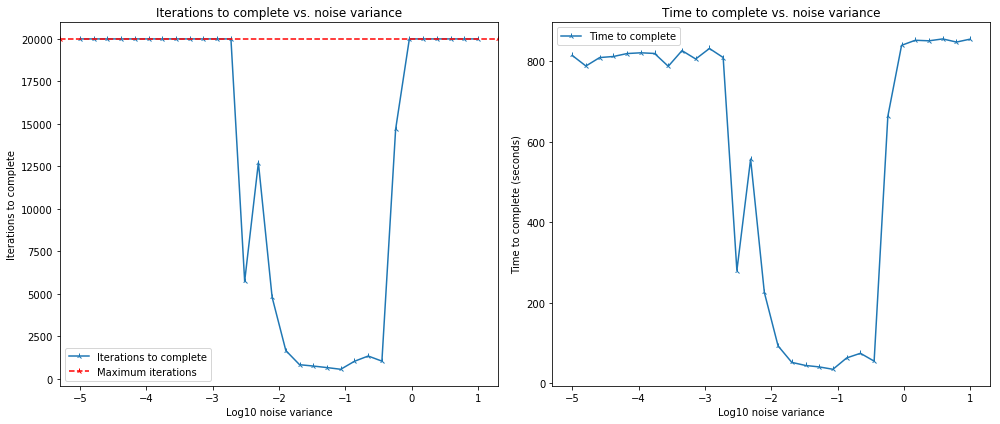

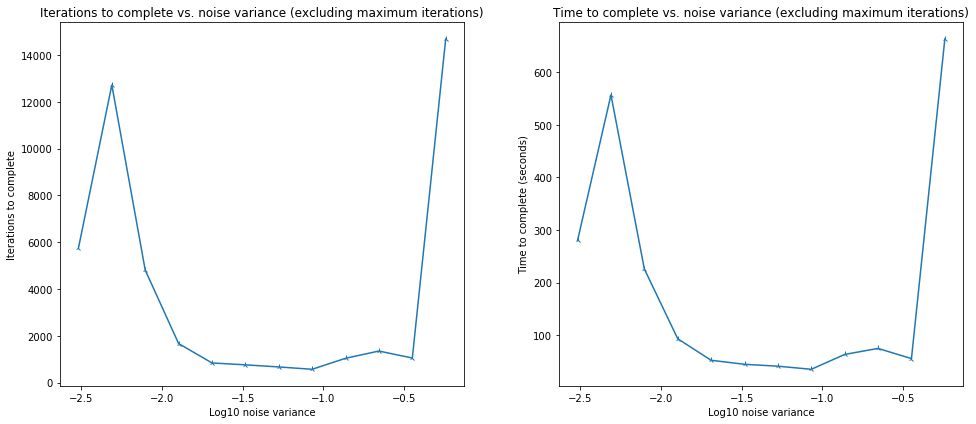

In [ ]:
import numpy as np
from concurrent.futures import ProcessPoolExecutor, as_completed
import matplotlib.pyplot as plt
import time

# Function to perform the simulation and fitting
def simulate_and_fit(v, n_repeat, n_iter_max, threshold_alpha_complete):
    iter_end_list_i = np.zeros(n_repeat)
    time_list_i = np.zeros(n_repeat)
    for j in range(n_repeat):
        start_time = time.time()
        d = simulate_data(psi=v**(-1), N=100)
        # variational inference
        # bpca = BPCA(a_alpha=1e-3, b_alpha=1e-3, a_tau=1e-3, b_tau=1e-3, beta=1e-3)
        # bpca.fit(
        #     d, iters=n_iter_max,
        #     threshold_alpha_complete=threshold_alpha_complete,
        #     true_signal_dim=4,
        #     fix_tau_at=v**(-1),
        # )
        # gibbs
        bpca = GibbsBayesianPCA(d, q=d.shape[1]-1, tau_init=v**(-1))
        bpca.fit(
            iterations=n_iter_max,
            threshold_alpha_complete=threshold_alpha_complete,
            true_signal_dim=4,
            fix_tau_at=v**(-1),
            )
        iter_end_list_i[j] = bpca.iter_converge
        time_list_i[j] = time.time() - start_time
    return np.mean(iter_end_list_i), np.mean(time_list_i)


# Specify the number of worker processes (e.g., 4)
num_workers = 30

r_list = []
# Use ProcessPoolExecutor to parallelize the loop
with ProcessPoolExecutor(max_workers=num_workers) as executor:
    futures = {executor.submit(simulate_and_fit, v, n_repeat, n_iter_max, threshold_alpha_complete): v for v in var_noise_list}
    for future in as_completed(futures):
        v = futures[future]
        mean_iter, mean_time = future.result()
        r_list.append((v, mean_iter, mean_time))
        print('Completed Variance: ', v)

# sort r_list by variance
r_list = sorted(r_list, key=lambda x: x[0])
v_list, iter_end_list, time_list = zip(*r_list)
# Convert lists to numpy arrays for plotting
iter_end_list = np.array(iter_end_list)
time_list = np.array(time_list)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot the number of iterations to converge
ax1.plot(np.log10(v_list), iter_end_list, label='Iterations to complete', marker='2')
ax1.axhline(y=n_iter_max, color='r', linestyle='--', label='Maximum iterations', marker='2')
ax1.set_xlabel('Log10 noise variance')
ax1.set_ylabel('Iterations to complete')
ax1.set_title('Iterations to complete vs. noise variance')
ax1.legend()

# Plot the time to converge
ax2.plot(np.log10(v_list), time_list, label='Time to complete', marker='2')
ax2.set_xlabel('Log10 noise variance')
ax2.set_ylabel('Time to complete (seconds)')
ax2.set_title('Time to complete vs. noise variance')
ax2.legend()

# Show the plots
plt.tight_layout()
plt.show()

# Show results excluding those reaching the maximum number of iterations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot the number of iterations to converge excluding max iterations
ax1.plot(np.log10(v_list)[iter_end_list < n_iter_max], iter_end_list[iter_end_list < n_iter_max], marker='2')
ax1.set_xlabel('Log10 noise variance')
ax1.set_ylabel('Iterations to complete')
ax1.set_title('Iterations to complete vs. noise variance (excluding maximum iterations)')

# Plot the time to converge excluding max iterations
ax2.plot(np.log10(v_list)[iter_end_list < n_iter_max], time_list[iter_end_list < n_iter_max], marker='2')
ax2.set_xlabel('Log10 noise variance')
ax2.set_ylabel('Time to complete (seconds)')
ax2.set_title('Time to complete vs. noise variance (excluding maximum iterations)')

# Show the plots
plt.tight_layout()
plt.show()

In [ ]:
var_noise_list = np.logspace(-5, 1, 30)
threshold_alpha_complete = 1e2
iter_end_list = np.zeros(len(var_noise_list))
# variational inference
n_iter_max = 200000
# gibbs
# n_iter_max = 20000
n_repeat = 1

In [ ]:
var_noise_list = np.logspace(-5, 1, 30)
threshold_alpha_complete = 1e2
iter_end_list = np.zeros(len(var_noise_list))
# variational inference
n_iter_max = 200000
# gibbs
# n_iter_max = 20000
n_repeat = 1

Completed Variance:  0.137382379588
Completed Variance:  0.221221629107
Completed Variance:  0.0853167852417
Completed Variance:  0.0529831690628
Completed Variance:  0.0329034456231
Completed Variance:  0.0204335971786
Completed Variance:  0.0126896100317
Completed Variance:  0.00788046281567
Completed Variance:  0.00303919538231
Completed Variance:  0.00188739182214
Completed Variance:  0.00489390091848
Completed Variance:  0.00117210229753
Completed Variance:  0.000727895384398
Completed Variance:  0.000452035365636
Completed Variance:  0.000280721620394
Completed Variance:  3.85662042116
Completed Variance:  0.356224789026
Completed Variance:  4.17531893656e-05
Completed Variance:  0.00017433288222
Completed Variance:  0.000108263673387
Completed Variance:  1.48735210729
Completed Variance:  1e-05
Completed Variance:  1.61026202756e-05
Completed Variance:  0.573615251045
Completed Variance:  2.39502661999
Completed Variance:  6.7233575365e-05
Completed Variance:  6.21016941892
Comp

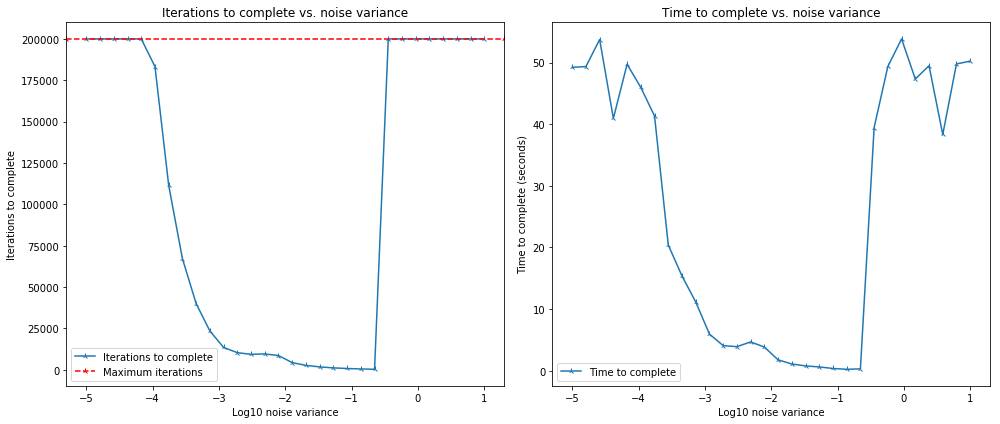

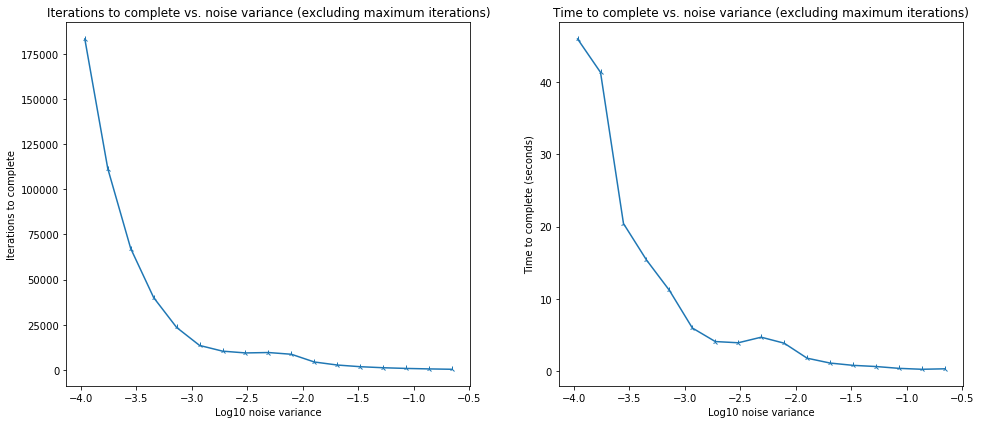

In [ ]:
import numpy as np
from concurrent.futures import ProcessPoolExecutor, as_completed
import matplotlib.pyplot as plt
import time

# Function to perform the simulation and fitting
def simulate_and_fit(v, n_repeat, n_iter_max, threshold_alpha_complete):
    iter_end_list_i = np.zeros(n_repeat)
    time_list_i = np.zeros(n_repeat)
    for j in range(n_repeat):
        start_time = time.time()
        d = simulate_data(psi=v**(-1), N=100)
        # variational inference
        bpca = BPCA(a_alpha=1e-3, b_alpha=1e-3, a_tau=1e-3, b_tau=1e-3, beta=1e-3)
        bpca.fit(
            d, iters=n_iter_max,
            threshold_alpha_complete=threshold_alpha_complete,
            true_signal_dim=4,
            fix_tau_at=v**(-1),
        )
        # gibbs
        # bpca = GibbsBayesianPCA(d, q=d.shape[1]-1, tau_init=v**(-1))
        # bpca.fit(
        #     iterations=n_iter_max,
        #     threshold_alpha_complete=threshold_alpha_complete,
        #     true_signal_dim=4,
        #     fix_tau_at=v**(-1),
        #     )
        iter_end_list_i[j] = bpca.iter_converge
        time_list_i[j] = time.time() - start_time
    return np.mean(iter_end_list_i), np.mean(time_list_i)


# Specify the number of worker processes (e.g., 4)
num_workers = 30

r_list = []
# Use ProcessPoolExecutor to parallelize the loop
with ProcessPoolExecutor(max_workers=num_workers) as executor:
    futures = {executor.submit(simulate_and_fit, v, n_repeat, n_iter_max, threshold_alpha_complete): v for v in var_noise_list}
    for future in as_completed(futures):
        v = futures[future]
        mean_iter, mean_time = future.result()
        r_list.append((v, mean_iter, mean_time))
        print('Completed Variance: ', v)

# sort r_list by variance
r_list = sorted(r_list, key=lambda x: x[0])
v_list, iter_end_list, time_list = zip(*r_list)
# Convert lists to numpy arrays for plotting
iter_end_list = np.array(iter_end_list)
time_list = np.array(time_list)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot the number of iterations to converge
ax1.plot(np.log10(v_list), iter_end_list, label='Iterations to complete', marker='2')
ax1.axhline(y=n_iter_max, color='r', linestyle='--', label='Maximum iterations', marker='2')
ax1.set_xlabel('Log10 noise variance')
ax1.set_ylabel('Iterations to complete')
ax1.set_title('Iterations to complete vs. noise variance')
ax1.legend()

# Plot the time to converge
ax2.plot(np.log10(v_list), time_list, label='Time to complete', marker='2')
ax2.set_xlabel('Log10 noise variance')
ax2.set_ylabel('Time to complete (seconds)')
ax2.set_title('Time to complete vs. noise variance')
ax2.legend()

# Show the plots
plt.tight_layout()
plt.show()

# Show results excluding those reaching the maximum number of iterations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot the number of iterations to converge excluding max iterations
ax1.plot(np.log10(v_list)[iter_end_list < n_iter_max], iter_end_list[iter_end_list < n_iter_max], marker='2')
ax1.set_xlabel('Log10 noise variance')
ax1.set_ylabel('Iterations to complete')
ax1.set_title('Iterations to complete vs. noise variance (excluding maximum iterations)')

# Plot the time to converge excluding max iterations
ax2.plot(np.log10(v_list)[iter_end_list < n_iter_max], time_list[iter_end_list < n_iter_max], marker='2')
ax2.set_xlabel('Log10 noise variance')
ax2.set_ylabel('Time to complete (seconds)')
ax2.set_title('Time to complete vs. noise variance (excluding maximum iterations)')

# Show the plots
plt.tight_layout()
plt.show()

In [ ]:
var_noise_list = np.logspace(-5, 1, 30)
threshold_alpha_complete = 1e2
iter_end_list = np.zeros(len(var_noise_list))
# variational inference
n_iter_max = 200000
# gibbs
# n_iter_max = 20000
n_repeat = 1

Completed Variance:  0.221221629107
Completed Variance:  0.137382379588
Completed Variance:  0.0853167852417
Completed Variance:  0.0329034456231
Completed Variance:  0.0529831690628
Completed Variance:  0.0204335971786
Completed Variance:  0.0126896100317
Completed Variance:  0.00303919538231
Completed Variance:  0.00788046281567
Completed Variance:  0.00188739182214
Completed Variance:  0.00489390091848
Completed Variance:  0.00117210229753
Completed Variance:  0.000727895384398
Completed Variance:  0.000452035365636
Completed Variance:  0.000280721620394
Completed Variance:  0.00017433288222
Completed Variance:  1.61026202756e-05
Completed Variance:  1.48735210729
Completed Variance:  2.39502661999
Completed Variance:  0.000108263673387
Completed Variance:  1e-05
Completed Variance:  0.573615251045
Completed Variance:  6.21016941892
Completed Variance:  4.17531893656e-05
Completed Variance:  0.356224789026
Completed Variance:  3.85662042116
Completed Variance:  0.923670857187
Comple

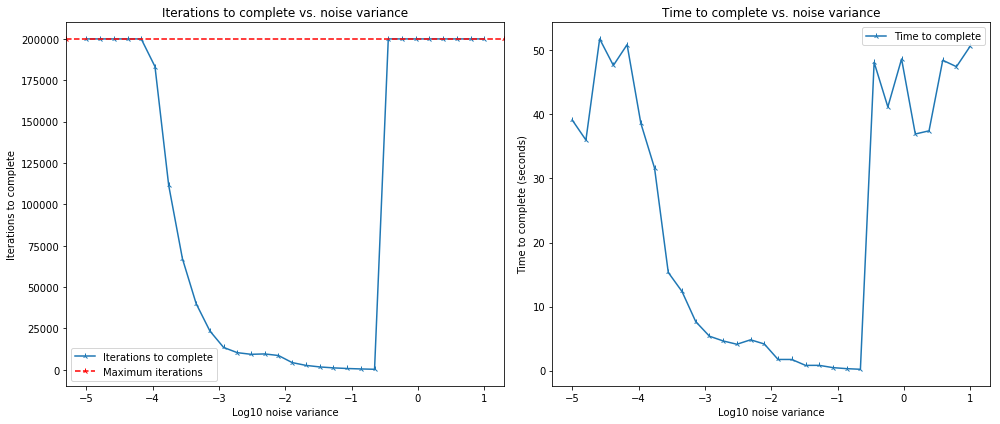

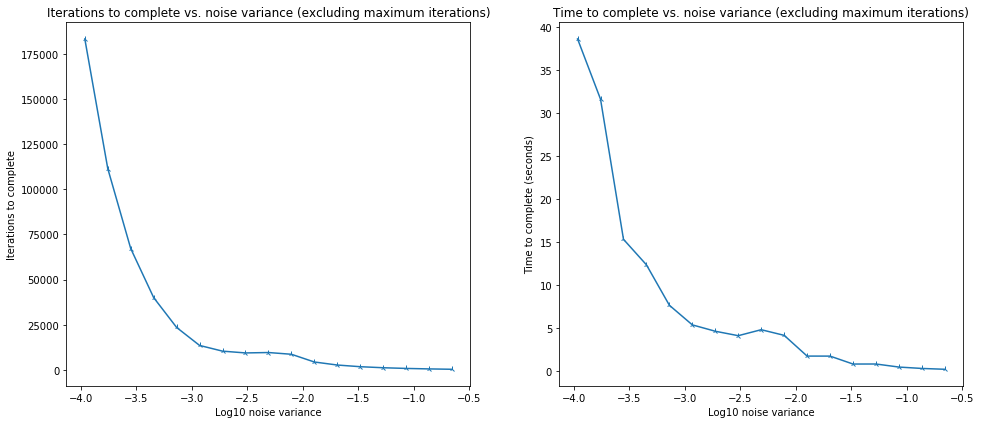

In [ ]:
import numpy as np
from concurrent.futures import ProcessPoolExecutor, as_completed
import matplotlib.pyplot as plt
import time

# Function to perform the simulation and fitting
def simulate_and_fit(v, n_repeat, n_iter_max, threshold_alpha_complete):
    iter_end_list_i = np.zeros(n_repeat)
    time_list_i = np.zeros(n_repeat)
    for j in range(n_repeat):
        start_time = time.time()
        d = simulate_data(psi=v**(-1), N=100)
        # variational inference
        bpca = BPCA(a_alpha=1e-3, b_alpha=1e-3, a_tau=1e-3, b_tau=1e-3, beta=1e-3)
        bpca.fit(
            d, iters=n_iter_max,
            threshold_alpha_complete=threshold_alpha_complete,
            true_signal_dim=4,
            # fix_tau_at=v**(-1),
            fix_tau_at=np.max(v, 1e-2)**(-1),
        )
        # gibbs
        # bpca = GibbsBayesianPCA(d, q=d.shape[1]-1, tau_init=v**(-1))
        # bpca.fit(
        #     iterations=n_iter_max,
        #     threshold_alpha_complete=threshold_alpha_complete,
        #     true_signal_dim=4,
        #     fix_tau_at=v**(-1),
        #     )
        iter_end_list_i[j] = bpca.iter_converge
        time_list_i[j] = time.time() - start_time
    return np.mean(iter_end_list_i), np.mean(time_list_i)


# Specify the number of worker processes (e.g., 4)
num_workers = 30

r_list = []
# Use ProcessPoolExecutor to parallelize the loop
with ProcessPoolExecutor(max_workers=num_workers) as executor:
    futures = {executor.submit(simulate_and_fit, v, n_repeat, n_iter_max, threshold_alpha_complete): v for v in var_noise_list}
    for future in as_completed(futures):
        v = futures[future]
        mean_iter, mean_time = future.result()
        r_list.append((v, mean_iter, mean_time))
        print('Completed Variance: ', v)

# sort r_list by variance
r_list = sorted(r_list, key=lambda x: x[0])
v_list, iter_end_list, time_list = zip(*r_list)
# Convert lists to numpy arrays for plotting
iter_end_list = np.array(iter_end_list)
time_list = np.array(time_list)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot the number of iterations to converge
ax1.plot(np.log10(v_list), iter_end_list, label='Iterations to complete', marker='2')
ax1.axhline(y=n_iter_max, color='r', linestyle='--', label='Maximum iterations', marker='2')
ax1.set_xlabel('Log10 noise variance')
ax1.set_ylabel('Iterations to complete')
ax1.set_title('Iterations to complete vs. noise variance')
ax1.legend()

# Plot the time to converge
ax2.plot(np.log10(v_list), time_list, label='Time to complete', marker='2')
ax2.set_xlabel('Log10 noise variance')
ax2.set_ylabel('Time to complete (seconds)')
ax2.set_title('Time to complete vs. noise variance')
ax2.legend()

# Show the plots
plt.tight_layout()
plt.show()

# Show results excluding those reaching the maximum number of iterations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot the number of iterations to converge excluding max iterations
ax1.plot(np.log10(v_list)[iter_end_list < n_iter_max], iter_end_list[iter_end_list < n_iter_max], marker='2')
ax1.set_xlabel('Log10 noise variance')
ax1.set_ylabel('Iterations to complete')
ax1.set_title('Iterations to complete vs. noise variance (excluding maximum iterations)')

# Plot the time to converge excluding max iterations
ax2.plot(np.log10(v_list)[iter_end_list < n_iter_max], time_list[iter_end_list < n_iter_max], marker='2')
ax2.set_xlabel('Log10 noise variance')
ax2.set_ylabel('Time to complete (seconds)')
ax2.set_title('Time to complete vs. noise variance (excluding maximum iterations)')

# Show the plots
plt.tight_layout()
plt.show()

In [ ]:
var_noise_list = np.logspace(-5, 1, 30)
threshold_alpha_complete = 1e2
iter_end_list = np.zeros(len(var_noise_list))
# variational inference
n_iter_max = 200000
# gibbs
# n_iter_max = 20000
n_repeat = 1

In [ ]:
import numpy as np
from concurrent.futures import ProcessPoolExecutor, as_completed
import matplotlib.pyplot as plt
import time

# Function to perform the simulation and fitting
def simulate_and_fit(v, n_repeat, n_iter_max, threshold_alpha_complete):
    iter_end_list_i = np.zeros(n_repeat)
    time_list_i = np.zeros(n_repeat)
    for j in range(n_repeat):
        start_time = time.time()
        d = simulate_data(psi=v**(-1), N=100)
        # variational inference
        bpca = BPCA(a_alpha=1e-3, b_alpha=1e-3, a_tau=1e-3, b_tau=1e-3, beta=1e-3)
        bpca.fit(
            d, iters=n_iter_max,
            threshold_alpha_complete=threshold_alpha_complete,
            true_signal_dim=4,
            # fix_tau_at=v**(-1),
            fix_tau_at=np.max(v, 1e0)**(-1),
        )
        # gibbs
        # bpca = GibbsBayesianPCA(d, q=d.shape[1]-1, tau_init=v**(-1))
        # bpca.fit(
        #     iterations=n_iter_max,
        #     threshold_alpha_complete=threshold_alpha_complete,
        #     true_signal_dim=4,
        #     fix_tau_at=v**(-1),
        #     )
        iter_end_list_i[j] = bpca.iter_converge
        time_list_i[j] = time.time() - start_time
    return np.mean(iter_end_list_i), np.mean(time_list_i)


# Specify the number of worker processes (e.g., 4)
num_workers = 30

r_list = []
# Use ProcessPoolExecutor to parallelize the loop
with ProcessPoolExecutor(max_workers=num_workers) as executor:
    futures = {executor.submit(simulate_and_fit, v, n_repeat, n_iter_max, threshold_alpha_complete): v for v in var_noise_list}
    for future in as_completed(futures):
        v = futures[future]
        mean_iter, mean_time = future.result()
        r_list.append((v, mean_iter, mean_time))
        print('Completed Variance: ', v)

# sort r_list by variance
r_list = sorted(r_list, key=lambda x: x[0])
v_list, iter_end_list, time_list = zip(*r_list)
# Convert lists to numpy arrays for plotting
iter_end_list = np.array(iter_end_list)
time_list = np.array(time_list)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot the number of iterations to converge
ax1.plot(np.log10(v_list), iter_end_list, label='Iterations to complete', marker='2')
ax1.axhline(y=n_iter_max, color='r', linestyle='--', label='Maximum iterations', marker='2')
ax1.set_xlabel('Log10 noise variance')
ax1.set_ylabel('Iterations to complete')
ax1.set_title('Iterations to complete vs. noise variance')
ax1.legend()

# Plot the time to converge
ax2.plot(np.log10(v_list), time_list, label='Time to complete', marker='2')
ax2.set_xlabel('Log10 noise variance')
ax2.set_ylabel('Time to complete (seconds)')
ax2.set_title('Time to complete vs. noise variance')
ax2.legend()

# Show the plots
plt.tight_layout()
plt.show()

# Show results excluding those reaching the maximum number of iterations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot the number of iterations to converge excluding max iterations
ax1.plot(np.log10(v_list)[iter_end_list < n_iter_max], iter_end_list[iter_end_list < n_iter_max], marker='2')
ax1.set_xlabel('Log10 noise variance')
ax1.set_ylabel('Iterations to complete')
ax1.set_title('Iterations to complete vs. noise variance (excluding maximum iterations)')

# Plot the time to converge excluding max iterations
ax2.plot(np.log10(v_list)[iter_end_list < n_iter_max], time_list[iter_end_list < n_iter_max], marker='2')
ax2.set_xlabel('Log10 noise variance')
ax2.set_ylabel('Time to complete (seconds)')
ax2.set_title('Time to complete vs. noise variance (excluding maximum iterations)')

# Show the plots
plt.tight_layout()
plt.show()

ValueError: 'axis' entry is out of bounds

In [ ]:
var_noise_list = np.logspace(-5, 1, 30)
threshold_alpha_complete = 1e2
iter_end_list = np.zeros(len(var_noise_list))
# variational inference
n_iter_max = 200000
# gibbs
# n_iter_max = 20000
n_repeat = 1

In [ ]:
var_noise_list = np.logspace(-5, 1, 30)
threshold_alpha_complete = 1e2
iter_end_list = np.zeros(len(var_noise_list))
# variational inference
n_iter_max = 200000
# gibbs
# n_iter_max = 20000
n_repeat = 1

Completed Variance:  0.221221629107
Completed Variance:  0.137382379588
Completed Variance:  0.0853167852417
Completed Variance:  0.0529831690628
Completed Variance:  0.0329034456231
Completed Variance:  0.0204335971786
Completed Variance:  0.0126896100317
Completed Variance:  0.00489390091848
Completed Variance:  0.00788046281567
Completed Variance:  0.00303919538231
Completed Variance:  0.00188739182214
Completed Variance:  0.00117210229753
Completed Variance:  0.000727895384398
Completed Variance:  0.000452035365636
Completed Variance:  0.000280721620394
Completed Variance:  6.7233575365e-05
Completed Variance:  0.00017433288222
Completed Variance:  0.000108263673387
Completed Variance:  4.17531893656e-05
Completed Variance:  10.0
Completed Variance:  0.923670857187
Completed Variance:  0.573615251045
Completed Variance:  0.356224789026
Completed Variance:  1e-05
Completed Variance:  3.85662042116
Completed Variance:  6.21016941892
Completed Variance:  1.61026202756e-05
Completed Va

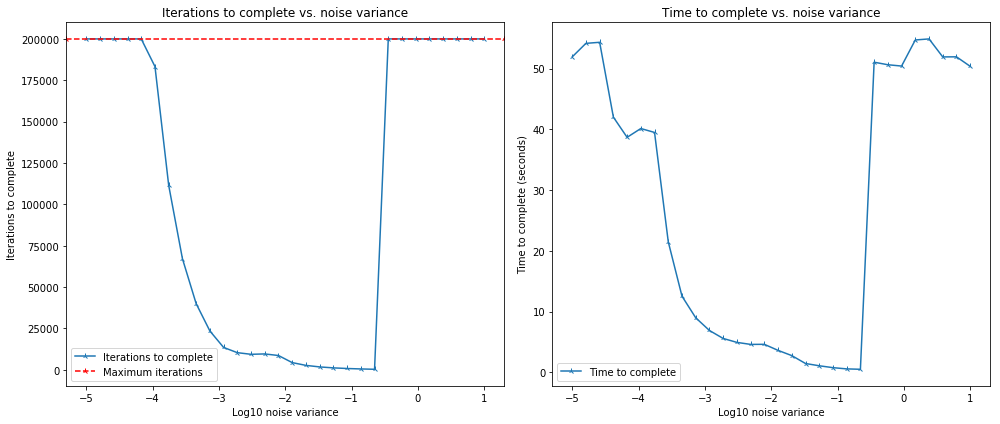

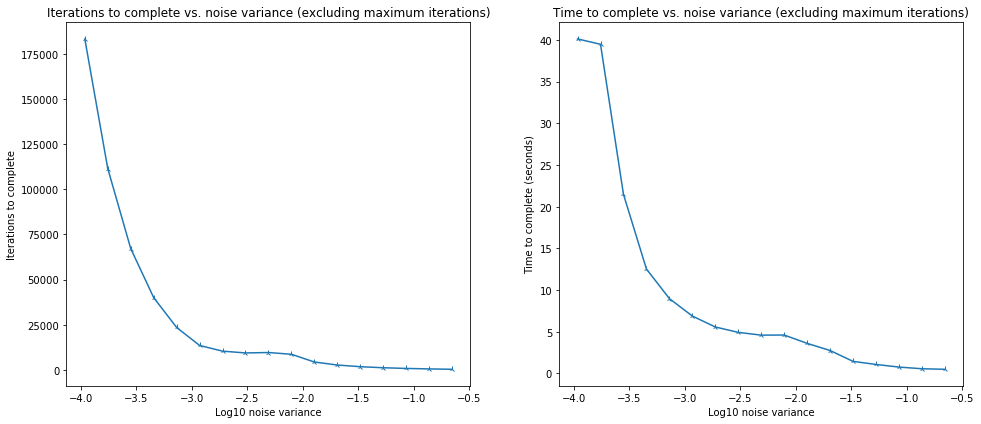

In [ ]:
import numpy as np
from concurrent.futures import ProcessPoolExecutor, as_completed
import matplotlib.pyplot as plt
import time

# Function to perform the simulation and fitting
def simulate_and_fit(v, n_repeat, n_iter_max, threshold_alpha_complete):
    iter_end_list_i = np.zeros(n_repeat)
    time_list_i = np.zeros(n_repeat)
    for j in range(n_repeat):
        start_time = time.time()
        d = simulate_data(psi=v**(-1), N=100)
        # variational inference
        bpca = BPCA(a_alpha=1e-3, b_alpha=1e-3, a_tau=1e-3, b_tau=1e-3, beta=1e-3)
        bpca.fit(
            d, iters=n_iter_max,
            threshold_alpha_complete=threshold_alpha_complete,
            true_signal_dim=4,
            # fix_tau_at=v**(-1),
            fix_tau_at=np.max(v, 1e-1)**(-1),
        )
        # gibbs
        # bpca = GibbsBayesianPCA(d, q=d.shape[1]-1, tau_init=v**(-1))
        # bpca.fit(
        #     iterations=n_iter_max,
        #     threshold_alpha_complete=threshold_alpha_complete,
        #     true_signal_dim=4,
        #     fix_tau_at=v**(-1),
        #     )
        iter_end_list_i[j] = bpca.iter_converge
        time_list_i[j] = time.time() - start_time
    return np.mean(iter_end_list_i), np.mean(time_list_i)


# Specify the number of worker processes (e.g., 4)
num_workers = 30

r_list = []
# Use ProcessPoolExecutor to parallelize the loop
with ProcessPoolExecutor(max_workers=num_workers) as executor:
    futures = {executor.submit(simulate_and_fit, v, n_repeat, n_iter_max, threshold_alpha_complete): v for v in var_noise_list}
    for future in as_completed(futures):
        v = futures[future]
        mean_iter, mean_time = future.result()
        r_list.append((v, mean_iter, mean_time))
        print('Completed Variance: ', v)

# sort r_list by variance
r_list = sorted(r_list, key=lambda x: x[0])
v_list, iter_end_list, time_list = zip(*r_list)
# Convert lists to numpy arrays for plotting
iter_end_list = np.array(iter_end_list)
time_list = np.array(time_list)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot the number of iterations to converge
ax1.plot(np.log10(v_list), iter_end_list, label='Iterations to complete', marker='2')
ax1.axhline(y=n_iter_max, color='r', linestyle='--', label='Maximum iterations', marker='2')
ax1.set_xlabel('Log10 noise variance')
ax1.set_ylabel('Iterations to complete')
ax1.set_title('Iterations to complete vs. noise variance')
ax1.legend()

# Plot the time to converge
ax2.plot(np.log10(v_list), time_list, label='Time to complete', marker='2')
ax2.set_xlabel('Log10 noise variance')
ax2.set_ylabel('Time to complete (seconds)')
ax2.set_title('Time to complete vs. noise variance')
ax2.legend()

# Show the plots
plt.tight_layout()
plt.show()

# Show results excluding those reaching the maximum number of iterations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot the number of iterations to converge excluding max iterations
ax1.plot(np.log10(v_list)[iter_end_list < n_iter_max], iter_end_list[iter_end_list < n_iter_max], marker='2')
ax1.set_xlabel('Log10 noise variance')
ax1.set_ylabel('Iterations to complete')
ax1.set_title('Iterations to complete vs. noise variance (excluding maximum iterations)')

# Plot the time to converge excluding max iterations
ax2.plot(np.log10(v_list)[iter_end_list < n_iter_max], time_list[iter_end_list < n_iter_max], marker='2')
ax2.set_xlabel('Log10 noise variance')
ax2.set_ylabel('Time to complete (seconds)')
ax2.set_title('Time to complete vs. noise variance (excluding maximum iterations)')

# Show the plots
plt.tight_layout()
plt.show()

In [ ]:
var_noise_list = np.logspace(-5, 1, 30)
threshold_alpha_complete = 1e2
iter_end_list = np.zeros(len(var_noise_list))
# variational inference
n_iter_max = 200000
# gibbs
# n_iter_max = 20000
n_repeat = 1

In [ ]:
import numpy as np
from concurrent.futures import ProcessPoolExecutor, as_completed
import matplotlib.pyplot as plt
import time

# Function to perform the simulation and fitting
def simulate_and_fit(v, n_repeat, n_iter_max, threshold_alpha_complete):
    iter_end_list_i = np.zeros(n_repeat)
    time_list_i = np.zeros(n_repeat)
    for j in range(n_repeat):
        start_time = time.time()
        d = simulate_data(psi=v**(-1), N=100)
        # variational inference
        bpca = BPCA(a_alpha=1e-3, b_alpha=1e-3, a_tau=1e-3, b_tau=1e-3, beta=1e-3)
        bpca.fit(
            d, iters=n_iter_max,
            threshold_alpha_complete=threshold_alpha_complete,
            true_signal_dim=4,
            # fix_tau_at=v**(-1),
            fix_tau_at=np.max(v, 1)**(-1),
        )
        # gibbs
        # bpca = GibbsBayesianPCA(d, q=d.shape[1]-1, tau_init=v**(-1))
        # bpca.fit(
        #     iterations=n_iter_max,
        #     threshold_alpha_complete=threshold_alpha_complete,
        #     true_signal_dim=4,
        #     fix_tau_at=v**(-1),
        #     )
        iter_end_list_i[j] = bpca.iter_converge
        time_list_i[j] = time.time() - start_time
    return np.mean(iter_end_list_i), np.mean(time_list_i)


# Specify the number of worker processes (e.g., 4)
num_workers = 30

r_list = []
# Use ProcessPoolExecutor to parallelize the loop
with ProcessPoolExecutor(max_workers=num_workers) as executor:
    futures = {executor.submit(simulate_and_fit, v, n_repeat, n_iter_max, threshold_alpha_complete): v for v in var_noise_list}
    for future in as_completed(futures):
        v = futures[future]
        mean_iter, mean_time = future.result()
        r_list.append((v, mean_iter, mean_time))
        print('Completed Variance: ', v)

# sort r_list by variance
r_list = sorted(r_list, key=lambda x: x[0])
v_list, iter_end_list, time_list = zip(*r_list)
# Convert lists to numpy arrays for plotting
iter_end_list = np.array(iter_end_list)
time_list = np.array(time_list)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot the number of iterations to converge
ax1.plot(np.log10(v_list), iter_end_list, label='Iterations to complete', marker='2')
ax1.axhline(y=n_iter_max, color='r', linestyle='--', label='Maximum iterations', marker='2')
ax1.set_xlabel('Log10 noise variance')
ax1.set_ylabel('Iterations to complete')
ax1.set_title('Iterations to complete vs. noise variance')
ax1.legend()

# Plot the time to converge
ax2.plot(np.log10(v_list), time_list, label='Time to complete', marker='2')
ax2.set_xlabel('Log10 noise variance')
ax2.set_ylabel('Time to complete (seconds)')
ax2.set_title('Time to complete vs. noise variance')
ax2.legend()

# Show the plots
plt.tight_layout()
plt.show()

# Show results excluding those reaching the maximum number of iterations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot the number of iterations to converge excluding max iterations
ax1.plot(np.log10(v_list)[iter_end_list < n_iter_max], iter_end_list[iter_end_list < n_iter_max], marker='2')
ax1.set_xlabel('Log10 noise variance')
ax1.set_ylabel('Iterations to complete')
ax1.set_title('Iterations to complete vs. noise variance (excluding maximum iterations)')

# Plot the time to converge excluding max iterations
ax2.plot(np.log10(v_list)[iter_end_list < n_iter_max], time_list[iter_end_list < n_iter_max], marker='2')
ax2.set_xlabel('Log10 noise variance')
ax2.set_ylabel('Time to complete (seconds)')
ax2.set_title('Time to complete vs. noise variance (excluding maximum iterations)')

# Show the plots
plt.tight_layout()
plt.show()

ValueError: 'axis' entry is out of bounds

In [ ]:
var_noise_list = np.logspace(-5, 1, 30)
threshold_alpha_complete = 1e2
iter_end_list = np.zeros(len(var_noise_list))
# variational inference
n_iter_max = 200000
# gibbs
# n_iter_max = 20000
n_repeat = 1

Completed Variance:  0.00489390091848
Completed Variance:  0.0126896100317
Completed Variance:  0.00017433288222
Completed Variance:  1.48735210729
Completed Variance:  0.00188739182214
Completed Variance:  0.356224789026
Completed Variance:  2.5929437974e-05
Completed Variance:  0.0529831690628
Completed Variance:  0.923670857187
Completed Variance:  0.00303919538231
Completed Variance:  0.221221629107
Completed Variance:  0.000108263673387
Completed Variance:  3.85662042116
Completed Variance:  0.0329034456231
Completed Variance:  0.00788046281567
Completed Variance:  0.573615251045
Completed Variance:  6.21016941892
Completed Variance:  10.0
Completed Variance:  0.00117210229753
Completed Variance:  0.0853167852417
Completed Variance:  0.000280721620394
Completed Variance:  4.17531893656e-05
Completed Variance:  1e-05
Completed Variance:  0.0204335971786
Completed Variance:  0.137382379588
Completed Variance:  0.000452035365636
Completed Variance:  2.39502661999
Completed Variance: 

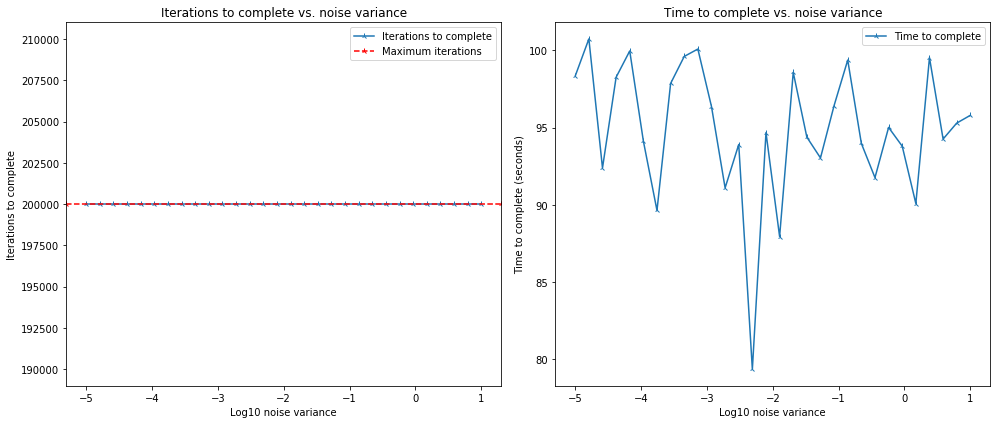

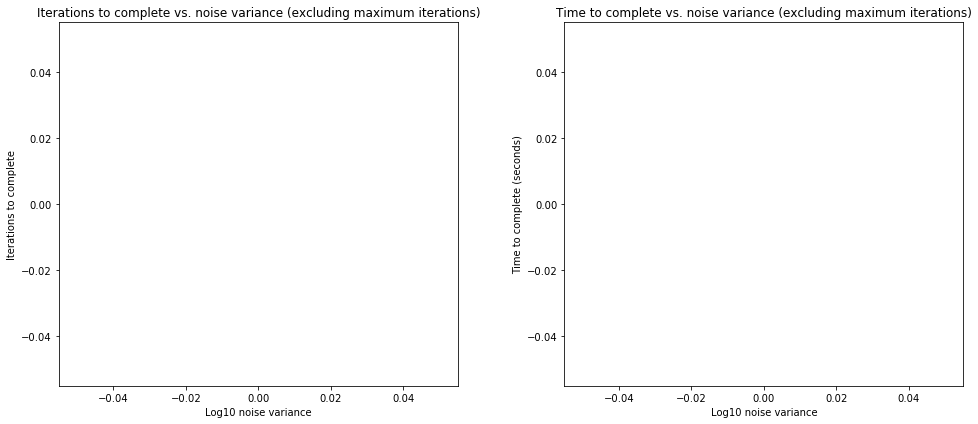

In [ ]:
import numpy as np
from concurrent.futures import ProcessPoolExecutor, as_completed
import matplotlib.pyplot as plt
import time

# Function to perform the simulation and fitting
def simulate_and_fit(v, n_repeat, n_iter_max, threshold_alpha_complete):
    iter_end_list_i = np.zeros(n_repeat)
    time_list_i = np.zeros(n_repeat)
    for j in range(n_repeat):
        start_time = time.time()
        d = simulate_data(psi=v**(-1), N=100)
        # variational inference
        bpca = BPCA(a_alpha=1e-3, b_alpha=1e-3, a_tau=1e-3, b_tau=1e-3, beta=1e-3)
        bpca.fit(
            d, iters=n_iter_max,
            threshold_alpha_complete=threshold_alpha_complete,
            true_signal_dim=4,
            # fix_tau_at=v**(-1),
            fix_tau_at=1,
        )
        # gibbs
        # bpca = GibbsBayesianPCA(d, q=d.shape[1]-1, tau_init=v**(-1))
        # bpca.fit(
        #     iterations=n_iter_max,
        #     threshold_alpha_complete=threshold_alpha_complete,
        #     true_signal_dim=4,
        #     fix_tau_at=v**(-1),
        #     )
        iter_end_list_i[j] = bpca.iter_converge
        time_list_i[j] = time.time() - start_time
    return np.mean(iter_end_list_i), np.mean(time_list_i)


# Specify the number of worker processes (e.g., 4)
num_workers = 30

r_list = []
# Use ProcessPoolExecutor to parallelize the loop
with ProcessPoolExecutor(max_workers=num_workers) as executor:
    futures = {executor.submit(simulate_and_fit, v, n_repeat, n_iter_max, threshold_alpha_complete): v for v in var_noise_list}
    for future in as_completed(futures):
        v = futures[future]
        mean_iter, mean_time = future.result()
        r_list.append((v, mean_iter, mean_time))
        print('Completed Variance: ', v)

# sort r_list by variance
r_list = sorted(r_list, key=lambda x: x[0])
v_list, iter_end_list, time_list = zip(*r_list)
# Convert lists to numpy arrays for plotting
iter_end_list = np.array(iter_end_list)
time_list = np.array(time_list)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot the number of iterations to converge
ax1.plot(np.log10(v_list), iter_end_list, label='Iterations to complete', marker='2')
ax1.axhline(y=n_iter_max, color='r', linestyle='--', label='Maximum iterations', marker='2')
ax1.set_xlabel('Log10 noise variance')
ax1.set_ylabel('Iterations to complete')
ax1.set_title('Iterations to complete vs. noise variance')
ax1.legend()

# Plot the time to converge
ax2.plot(np.log10(v_list), time_list, label='Time to complete', marker='2')
ax2.set_xlabel('Log10 noise variance')
ax2.set_ylabel('Time to complete (seconds)')
ax2.set_title('Time to complete vs. noise variance')
ax2.legend()

# Show the plots
plt.tight_layout()
plt.show()

# Show results excluding those reaching the maximum number of iterations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot the number of iterations to converge excluding max iterations
ax1.plot(np.log10(v_list)[iter_end_list < n_iter_max], iter_end_list[iter_end_list < n_iter_max], marker='2')
ax1.set_xlabel('Log10 noise variance')
ax1.set_ylabel('Iterations to complete')
ax1.set_title('Iterations to complete vs. noise variance (excluding maximum iterations)')

# Plot the time to converge excluding max iterations
ax2.plot(np.log10(v_list)[iter_end_list < n_iter_max], time_list[iter_end_list < n_iter_max], marker='2')
ax2.set_xlabel('Log10 noise variance')
ax2.set_ylabel('Time to complete (seconds)')
ax2.set_title('Time to complete vs. noise variance (excluding maximum iterations)')

# Show the plots
plt.tight_layout()
plt.show()

In [ ]:
var_noise_list = np.logspace(-5, 1, 30)
threshold_alpha_complete = 1e2
iter_end_list = np.zeros(len(var_noise_list))
# variational inference
n_iter_max = 200000
# gibbs
# n_iter_max = 20000
n_repeat = 1

Completed Variance:  0.000727895384398
Completed Variance:  0.00117210229753
Completed Variance:  0.000280721620394
Completed Variance:  6.7233575365e-05
Completed Variance:  1.61026202756e-05
Completed Variance:  0.00188739182214
Completed Variance:  1e-05
Completed Variance:  0.000108263673387
Completed Variance:  0.000452035365636
Completed Variance:  0.00017433288222
Completed Variance:  4.17531893656e-05
Completed Variance:  0.00303919538231
Completed Variance:  2.5929437974e-05
Completed Variance:  0.0204335971786
Completed Variance:  0.00788046281567
Completed Variance:  0.00489390091848
Completed Variance:  0.0126896100317
Completed Variance:  0.221221629107
Completed Variance:  6.21016941892
Completed Variance:  0.137382379588
Completed Variance:  0.0529831690628
Completed Variance:  0.0853167852417
Completed Variance:  2.39502661999
Completed Variance:  3.85662042116
Completed Variance:  1.48735210729
Completed Variance:  10.0
Completed Variance:  0.923670857187
Completed Var

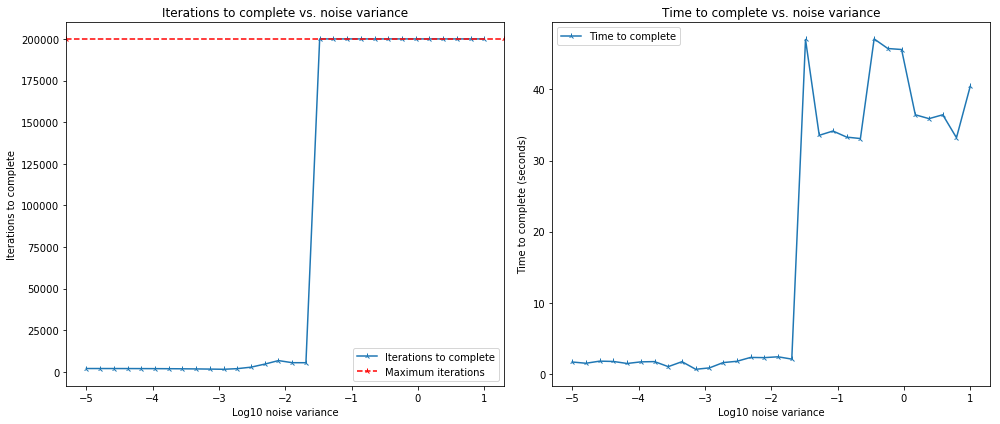

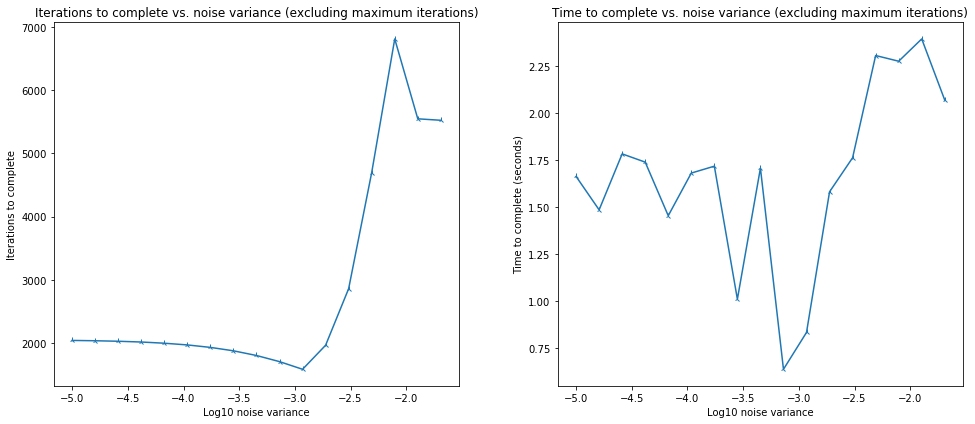

In [ ]:
import numpy as np
from concurrent.futures import ProcessPoolExecutor, as_completed
import matplotlib.pyplot as plt
import time

# Function to perform the simulation and fitting
def simulate_and_fit(v, n_repeat, n_iter_max, threshold_alpha_complete):
    iter_end_list_i = np.zeros(n_repeat)
    time_list_i = np.zeros(n_repeat)
    for j in range(n_repeat):
        start_time = time.time()
        d = simulate_data(psi=v**(-1), N=100)
        # variational inference
        bpca = BPCA(a_alpha=1e-3, b_alpha=1e-3, a_tau=1e-3, b_tau=1e-3, beta=1e-3)
        bpca.fit(
            d, iters=n_iter_max,
            threshold_alpha_complete=threshold_alpha_complete,
            true_signal_dim=4,
            # fix_tau_at=v**(-1),
            fix_tau_at=(1e-2)**(-1),
        )
        # gibbs
        # bpca = GibbsBayesianPCA(d, q=d.shape[1]-1, tau_init=v**(-1))
        # bpca.fit(
        #     iterations=n_iter_max,
        #     threshold_alpha_complete=threshold_alpha_complete,
        #     true_signal_dim=4,
        #     fix_tau_at=v**(-1),
        #     )
        iter_end_list_i[j] = bpca.iter_converge
        time_list_i[j] = time.time() - start_time
    return np.mean(iter_end_list_i), np.mean(time_list_i)


# Specify the number of worker processes (e.g., 4)
num_workers = 30

r_list = []
# Use ProcessPoolExecutor to parallelize the loop
with ProcessPoolExecutor(max_workers=num_workers) as executor:
    futures = {executor.submit(simulate_and_fit, v, n_repeat, n_iter_max, threshold_alpha_complete): v for v in var_noise_list}
    for future in as_completed(futures):
        v = futures[future]
        mean_iter, mean_time = future.result()
        r_list.append((v, mean_iter, mean_time))
        print('Completed Variance: ', v)

# sort r_list by variance
r_list = sorted(r_list, key=lambda x: x[0])
v_list, iter_end_list, time_list = zip(*r_list)
# Convert lists to numpy arrays for plotting
iter_end_list = np.array(iter_end_list)
time_list = np.array(time_list)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot the number of iterations to converge
ax1.plot(np.log10(v_list), iter_end_list, label='Iterations to complete', marker='2')
ax1.axhline(y=n_iter_max, color='r', linestyle='--', label='Maximum iterations', marker='2')
ax1.set_xlabel('Log10 noise variance')
ax1.set_ylabel('Iterations to complete')
ax1.set_title('Iterations to complete vs. noise variance')
ax1.legend()

# Plot the time to converge
ax2.plot(np.log10(v_list), time_list, label='Time to complete', marker='2')
ax2.set_xlabel('Log10 noise variance')
ax2.set_ylabel('Time to complete (seconds)')
ax2.set_title('Time to complete vs. noise variance')
ax2.legend()

# Show the plots
plt.tight_layout()
plt.show()

# Show results excluding those reaching the maximum number of iterations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot the number of iterations to converge excluding max iterations
ax1.plot(np.log10(v_list)[iter_end_list < n_iter_max], iter_end_list[iter_end_list < n_iter_max], marker='2')
ax1.set_xlabel('Log10 noise variance')
ax1.set_ylabel('Iterations to complete')
ax1.set_title('Iterations to complete vs. noise variance (excluding maximum iterations)')

# Plot the time to converge excluding max iterations
ax2.plot(np.log10(v_list)[iter_end_list < n_iter_max], time_list[iter_end_list < n_iter_max], marker='2')
ax2.set_xlabel('Log10 noise variance')
ax2.set_ylabel('Time to complete (seconds)')
ax2.set_title('Time to complete vs. noise variance (excluding maximum iterations)')

# Show the plots
plt.tight_layout()
plt.show()

In [ ]:
var_noise_list = np.logspace(-5, 1, 30)
threshold_alpha_complete = 1e2
iter_end_list = np.zeros(len(var_noise_list))
n_repeat = 1

Iteration  100
Iteration  100
Iteration  100
Iteration  100
Iteration  100
Iteration  100
Iteration  100
Iteration  100
Iteration  100
Iteration  100
Iteration  100
Iteration  100
Iteration  100
Iteration  100
Iteration  100
Iteration  100
Iteration  100
Iteration  100
Iteration  100
Iteration  100
Iteration  100
Iteration  100
Iteration  100
Iteration  100
Iteration  100
Iteration  100
Iteration  100
Iteration  100
Iteration  200
Iteration  100
Iteration  100
Iteration  200
Iteration  200
Iteration  200
Iteration  200
Iteration  200
Iteration  200
Iteration  200
Iteration  200
Iteration  200
Iteration  200
Iteration  200
Iteration  200
Iteration  200
Iteration  200
Iteration  200
Iteration  200
Iteration  200
Iteration  200
Iteration  200
Iteration  200
Iteration  200
Iteration  200
Iteration  200
Iteration  200
Iteration  300
Iteration  200
Iteration  200
Iteration  200
Iteration  300
Iteration  300
Iteration  300
Iteration  200
Iteration  200
Iteration  300
Iteration  300
Iteration 

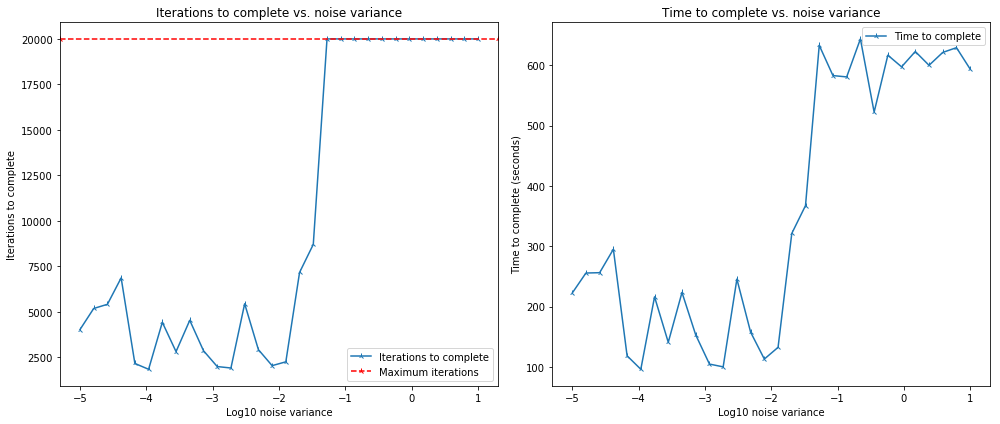

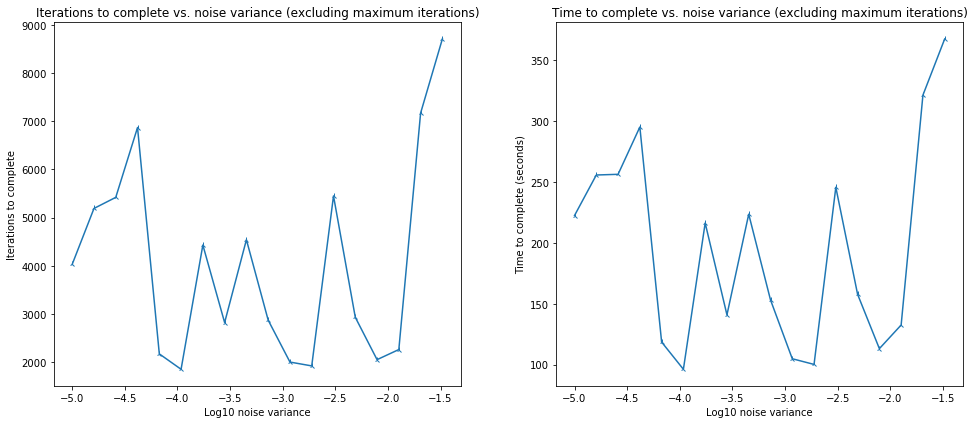

In [ ]:
import numpy as np
from concurrent.futures import ProcessPoolExecutor, as_completed
import matplotlib.pyplot as plt
import time
# variational inference
# n_iter_max = 200000
# gibbs
n_iter_max = 20000

# Function to perform the simulation and fitting
def simulate_and_fit(v, n_repeat, n_iter_max, threshold_alpha_complete):
    iter_end_list_i = np.zeros(n_repeat)
    time_list_i = np.zeros(n_repeat)
    for j in range(n_repeat):
        start_time = time.time()
        d = simulate_data(psi=v**(-1), N=100)
        # variational inference
        # bpca = BPCA(a_alpha=1e-3, b_alpha=1e-3, a_tau=1e-3, b_tau=1e-3, beta=1e-3)
        # bpca.fit(
        #     d, iters=n_iter_max,
        #     threshold_alpha_complete=threshold_alpha_complete,
        #     true_signal_dim=4,
        #     # fix_tau_at=v**(-1),
        #     fix_tau_at=(1e-2)**(-1),
        # )
        # gibbs
        bpca = GibbsBayesianPCA(d, q=d.shape[1]-1, tau_init=v**(-1))
        bpca.fit(
            iterations=n_iter_max,
            threshold_alpha_complete=threshold_alpha_complete,
            true_signal_dim=4,
            # fix_tau_at=v**(-1),
            fix_tau_at=(1e-2)**(-1),
            )
        iter_end_list_i[j] = bpca.iter_converge
        time_list_i[j] = time.time() - start_time
    return np.mean(iter_end_list_i), np.mean(time_list_i)


# Specify the number of worker processes (e.g., 4)
num_workers = 30

r_list = []
# Use ProcessPoolExecutor to parallelize the loop
with ProcessPoolExecutor(max_workers=num_workers) as executor:
    futures = {executor.submit(simulate_and_fit, v, n_repeat, n_iter_max, threshold_alpha_complete): v for v in var_noise_list}
    for future in as_completed(futures):
        v = futures[future]
        mean_iter, mean_time = future.result()
        r_list.append((v, mean_iter, mean_time))
        print('Completed Variance: ', v)

# sort r_list by variance
r_list = sorted(r_list, key=lambda x: x[0])
v_list, iter_end_list, time_list = zip(*r_list)
# Convert lists to numpy arrays for plotting
iter_end_list = np.array(iter_end_list)
time_list = np.array(time_list)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot the number of iterations to converge
ax1.plot(np.log10(v_list), iter_end_list, label='Iterations to complete', marker='2')
ax1.axhline(y=n_iter_max, color='r', linestyle='--', label='Maximum iterations', marker='2')
ax1.set_xlabel('Log10 noise variance')
ax1.set_ylabel('Iterations to complete')
ax1.set_title('Iterations to complete vs. noise variance')
ax1.legend()

# Plot the time to converge
ax2.plot(np.log10(v_list), time_list, label='Time to complete', marker='2')
ax2.set_xlabel('Log10 noise variance')
ax2.set_ylabel('Time to complete (seconds)')
ax2.set_title('Time to complete vs. noise variance')
ax2.legend()

# Show the plots
plt.tight_layout()
plt.show()

# Show results excluding those reaching the maximum number of iterations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot the number of iterations to converge excluding max iterations
ax1.plot(np.log10(v_list)[iter_end_list < n_iter_max], iter_end_list[iter_end_list < n_iter_max], marker='2')
ax1.set_xlabel('Log10 noise variance')
ax1.set_ylabel('Iterations to complete')
ax1.set_title('Iterations to complete vs. noise variance (excluding maximum iterations)')

# Plot the time to converge excluding max iterations
ax2.plot(np.log10(v_list)[iter_end_list < n_iter_max], time_list[iter_end_list < n_iter_max], marker='2')
ax2.set_xlabel('Log10 noise variance')
ax2.set_ylabel('Time to complete (seconds)')
ax2.set_title('Time to complete vs. noise variance (excluding maximum iterations)')

# Show the plots
plt.tight_layout()
plt.show()